In [3]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.value_models import ValueLinearModel, ValueNormedModel
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import scipy.stats as stats

import torch

In [18]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [23]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

In [5]:
sf = behavioral_utils.get_selection_features(valid_beh)

In [6]:
sf["NextColor"] = sf["Color"].shift(periods=-1)
sf["NextPattern"] = sf["Pattern"].shift(periods=-1)
sf["NextShape"] = sf["Shape"].shift(periods=-1)
sf["SharedFeatureNext"] = (
    (sf["Shape"] == sf["NextShape"]) |
    (sf["Pattern"] == sf["NextPattern"]) | 
    (sf["Color"] == sf["NextColor"])
)


In [19]:
valid_beh = valid_beh.merge(sf[["TrialNumber", "SharedFeatureNext"]], on="TrialNumber")

In [21]:
rng = np.random.default_rng(seed=42)
num_samples = 285 # smallest common number
not_share_feat_sampled = valid_beh[~valid_beh["SharedFeatureNext"]]
share_feat_sampled = valid_beh[valid_beh["SharedFeatureNext"]].sample(len(not_share_feat_sampled), random_state=rng)


In [25]:
share_fr = firing_rates[firing_rates.TrialNumber.isin(share_feat_sampled.TrialNumber)]
share_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(share_feat_sampled.TrialNumber)]

num_neurons = len(share_fr.UnitID.unique())
labels = np.sort(share_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = share_fr.rename(columns={mode: "Value"})
labels = share_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=share_card_idxs
)

np.save(fs.open(f"l2l.pqz317.scratch/value_normed_shared_feat_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/value_normed_shared_feat_model_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/value_normed_shared_feat_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/value_normed_shared_feat_model_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


In [26]:
not_share_fr = firing_rates[firing_rates.TrialNumber.isin(not_share_feat_sampled.TrialNumber)]
not_share_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(not_share_feat_sampled.TrialNumber)]

num_neurons = len(not_share_fr.UnitID.unique())
labels = np.sort(not_share_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = not_share_fr.rename(columns={mode: "Value"})
labels = not_share_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=not_share_card_idxs
)

np.save(fs.open(f"l2l.pqz317.scratch/value_normed_not_shared_feat_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/value_normed_not_shared_feat_model_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/value_normed_not_shared_feat_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/value_normed_not_shared_feat_model_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


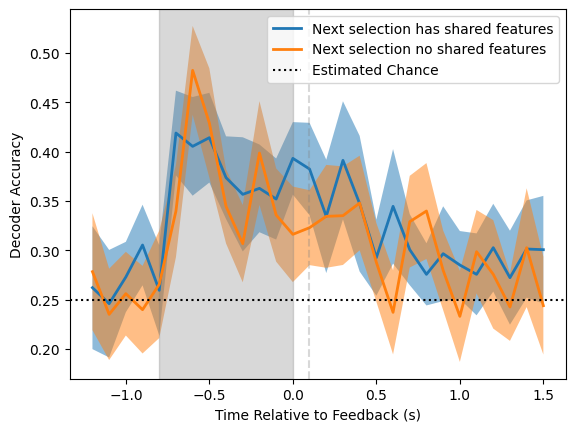

In [28]:
shared_acc_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_shared_feat_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
not_shared_acc_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_not_shared_feat_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    shared_acc_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Next selection has shared features",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_shared_acc_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Next selection no shared features",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
ax.legend()